# World Bank data

**Goal**: come up with actionable insights using KPIs from around the world using data from the World Bank. Some possible examples:

- what kinds of business are predicted to be on the rise in each country?
- which countries might be sensitive to different types of industry changes?
- pick a specific industry; make predictions for the future based on different KPIs in different countries

A major part of this data challenge is time management. Here's the initial schedule: let's see how well I can keep it. 

- 30 minutes: reading about the structure of the data and coming up with a question
- 30 minutes: explore the data (pivot tables, info summaries, quick plots, etc)
- 2 hours: build model
- 1 hour: make visualizations
- 45 minutes: reformat notebook for legibility and summarize the actionable insights at the top

## Outcome

I spent about 5-6 hours on this, scattered in chunks. Understanding the data was a little more tricky than I anticipated, given the number of indicators and the domain knowledge needed to interpret them. The World Bank website itself has a very good API and plotting package associated with it, so that I really didn't need much of this separate notebook. A lot of my analysis could have been done *in situ*. 

I ended up looking at countries that were **experiencing the highest levels of energy depletion**, defined as the ratio of the value of their current stock to remaining future reserves. I wanted to find the countries that had the highest rates (who are potentially facing near-term financial and energy crises) and see if this related to their likelihood of diversifying and investing in other areas. 

The **Middle East & North Africa** as a region has the highest energy depletion rate (EDR) in the world (peaking as high as 20% of their gross national index, currently at around 10%). Within the region, there's significant diversity; small, currently oil-rich countries like Bahrain and Qatar have among the highest EDRs, while cultural and geographic outliers like Israel, Malta, and Morocco have among the lowest EDRs.

Splitting the countries in the region by EDR, I looked at their investment in three areas that would be more "renewable" and potentially profitable: tourism, research & development, and education. All countries with low EDR spend more of their gross national index in each of these areas; of the "at-risk" countries with high EDR, though, there wasn't any strong increase in these indices in the last five years (with a couple exceptions: Oman is increasing spending on education, and Qatar is getting more income from tourism). These aren't strong signs for the future of the citizens in these countries. 

Future work would be to explore this for the remainder of the countries in the dataset and to find historical trends of countries that had high EDRs and then re-invested in the development indicators above. That would be useful data to put into a training model and predict which of the countries in the Middle East & North Africa are capable of bucking the trend.

In [194]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Step 1 (30 minutes) - content/structure of data and coming up with a question

10:41am start

These are *development indicators* - measuring lots of different metrics about all of the countries in the world (217 by the WB count). It's updated regularly (every three months, or quarterly) and is aggregated from a number of international sources. This is a very current dataset, with the most recent on 10 Aug 2016 (two weeks ago). 

Source of data is http://data.worldbank.org/data-catalog/world-development-indicators - I got the product as a bulk download of a zipped CSV file. Looks to be several different tables; if they're meant to be linked, then this might be appropriate for either using merged Pandas dataframes or inserting them into an SQL database. 

In [5]:
import os

In [31]:
# Explore each table

data_path = "../dc"

csnotes = pd.read_csv(os.path.join(data_path,'WDI_CS_Notes.csv'))
"""csnotes.head()
csnotes.info()
"""
country = pd.read_csv(os.path.join(data_path,'WDI_Country.csv'))
"""country.head()
country.info()
"""
data = pd.read_csv(os.path.join(data_path,'WDI_Data.csv'))
"""data.head()
data.info()"""

description = pd.read_csv(os.path.join(data_path,'WDI_Description.csv'))
"""description.head()
description.info()"""

footnotes = pd.read_csv(os.path.join(data_path,'WDI_Footnotes.csv'))
"""footnotes.head()
footnotes.info()"""

stnotes = pd.read_csv(os.path.join(data_path,'WDI_ST_Notes.csv'))
"""stnotes.head()
"""
series = pd.read_csv(os.path.join(data_path,'WDI_Series.csv'))
"""series.head()
series.info()"""

,CountryCode,SeriesCode,DESCRIPTION
0,ABW,EG.EGY.PRIM.PP.KD,Sources: Estimated based on UN Energy Statisti...
1,ABW,EG.ELC.RNEW.ZS,Sources: UN Energy Statistics (2014)
2,ABW,EG.FEC.RNEW.ZS,Sources: UN Energy Statistics (2014)
3,ABW,IT.CEL.SETS,Servicio di Telecomunicacion di Aruba (SETAR)....
4,ABW,IT.CEL.SETS.P2,Servicio di Telecomunicacion di Aruba (SETAR)....


Summarize the contents.

- **csnotes** contains descriptions on some of the series. There can be multiple descriptions for any one series (eg, 285 unique codes, but 6214 rows in this table).
- **country** contains name demographic, and group information for all the entries in the system. 263 total entries, 1 per country.
- **data** is the meat of the dataset. Each row corresponds to a country and an indicator, with columns giving the value of that indicator (if present) for the years between 1960 and 2015.
- **description** is a text file summarizing various changes and addenda to the data set since the initial bulk import.
- **footnotes** gives information on specific (country + series code + year) combinations. Not explicitly linked to other tables, but one could search for existing footnotes relating to a dataset you're interested in plotting. 
- **stnotes** gives information on specific (series code + year) combinations
- **series** provides the metadata for each time series, including things like units, provenance of data, and various categories.

In [350]:
# So I'll want to look at one or more indicators from the timeseries.
# Looking more closely at what's available.

for code,ld in zip(series['Series Code'],series['Long definition']):
    print "{}, {}\n".format(code,ld)

AG.AGR.TRAC.NO, Agricultural machinery refers to the number of wheel and crawler tractors (excluding garden tractors) in use in agriculture at the end of the calendar year specified or during the first quarter of the following year.

AG.CON.FERT.PT.ZS, Fertilizer consumption measures the quantity of plant nutrients used per unit of arable land. Fertilizer products cover nitrogenous, potash, and phosphate fertilizers (including ground rock phosphate). Traditional nutrients--animal and plant manures--are not included. For the purpose of data dissemination, FAO has adopted the concept of a calendar year (January to December). Some countries compile fertilizer data on a calendar year basis, while others are on a split-year basis.

AG.CON.FERT.ZS, Fertilizer consumption measures the quantity of plant nutrients used per unit of arable land. Fertilizer products cover nitrogenous, potash, and phosphate fertilizers (including ground rock phosphate). Traditional nutrients--animal and plant manur

Notes:

- geographic indices (susceptibility to climate change)
- scientific and technical output (journals, patents, trademarks)
- education expenditures, literacy rates, student/teacher ratios, researchers/technicians in R&D
- Internet users
- **energy/natural resource depletion - which countries are running out of products? are they making it up in other sectors? do they have the savings to deal with it? relate to labor force participation**
- health/mortality rates

In [246]:
# Net forest depletion, mineral depletion, energy depletion = natural resource depletion

s = set()
for i in xrange(len(series)):
    if "atural resource depletion" in series.iloc[i]['Long definition'] or \
    "nergy depletion" in series.iloc[i]['Long definition'] or \
    "ineral depletion" in series.iloc[i]['Long definition'] or \
    "forest depletion" in series.iloc[i]['Long definition']:
        s.add(i)

In [247]:
for n in series.iloc[list(s)]['Indicator Name']:
    print n

Adjusted net savings, including particulate emission damage (current US$)
Adjusted net savings, including particulate emission damage (% of GNI)
Adjusted net savings, excluding particulate emission damage (current US$)
Adjusted net savings, excluding particulate emission damage (% of GNI)
Adjusted savings: net forest depletion (current US$)
Adjusted savings: net forest depletion (% of GNI)
Adjusted savings: mineral depletion (current US$)
Adjusted savings: mineral depletion (% of GNI)
Adjusted savings: energy depletion (current US$)
Adjusted savings: energy depletion (% of GNI)
Adjusted savings: natural resources depletion (% of GNI)


In [71]:
list(s)

[774, 775, 776, 777, 754, 755, 758, 759, 760, 761, 764]

In [85]:
series.iloc[754:756][['Long definition','Series Code']]

,Long definition,Series Code
754,Net forest depletion is calculated as the prod...,NY.ADJ.DFOR.CD
755,Net forest depletion is calculated as the prod...,NY.ADJ.DFOR.GN.ZS


In [243]:
series.iloc[761]

Series Code                                                            NY.ADJ.DNGY.GN.ZS
Topic                                  Economic Policy & Debt: National accounts: Adj...
Indicator Name                             Adjusted savings: energy depletion (% of GNI)
Short definition                                                                     NaN
Long definition                        Energy depletion is the ratio of the value of ...
Unit of measure                                                                      NaN
Periodicity                                                                       Annual
Base Period                                                                          NaN
Other notes                                                                          NaN
Aggregation method                                                      Weighted average
Limitations and exceptions                                                           NaN
Notes from original s

In [224]:
def column_cleanup(df):
    dfnew = df.rename(columns={"Sub-Saharan Africa": "Sub-Saharan Africa (all)",
                   "Sub-Saharan Africa (IDA & IBRD countries)": "Sub-Saharan Africa", 
                   "Middle East & North Africa (IDA & IBRD countries)": "Middle East & North Africa"})
    return dfnew

region_columns = ["Sub-Saharan Africa",
    "East Asia & Pacific",
    "Europe & Central Asia",
    "Latin America & Caribbean",
    "Middle East & North Africa",
    "South Asia"]

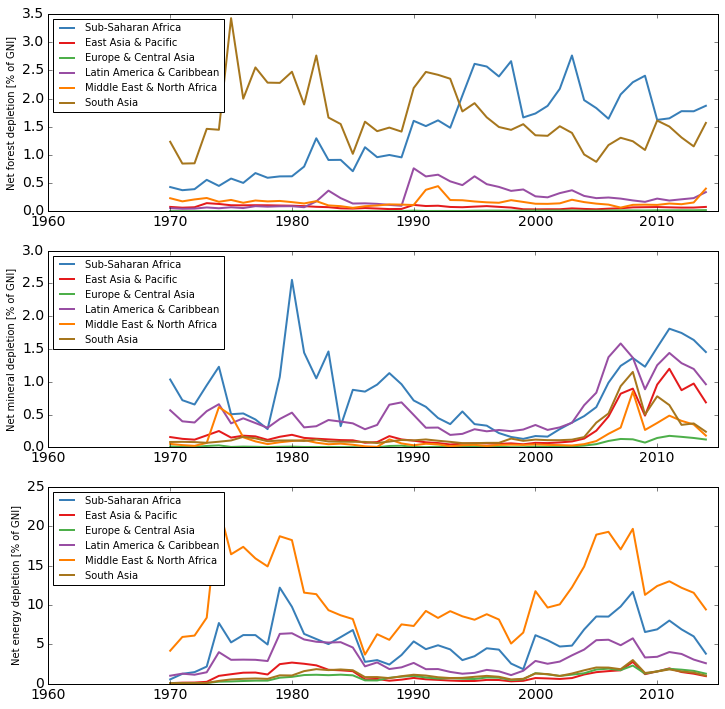

In [237]:
depletion_codes = ["NY.ADJ.DFOR.GN.ZS","NY.ADJ.DMIN.GN.ZS","NY.ADJ.DNGY.GN.ZS"]
labels = ["forest","mineral","energy"]

fig,axarr = plt.subplots(3,1,figsize=(12,12))

for code,label,ax in zip(depletion_codes,labels,axarr.ravel()):
    d = data[data['Indicator Code'] == code]

    # Limit to countries with at least 20 non-NaN data points?

    d = d[np.isnan(d[d.columns[4:]]).sum(axis=1) < 12]

    d.index = d['Country Name']
    dt = d[d.columns[4:]].T

    dt = column_cleanup(dt)
    dt[region_columns].plot(ax=ax,legend=True,fontsize=14)
    ax.set_ylabel("Net {} depletion [% of GNI]".format(label),fontsize=10)
    ax.legend(fontsize=10,loc='upper left');

### Let's analyze the results of each of these, separated by major region. 

Net forest depletion is the product of the rents derived by harvesting timber and the excess amount of wood production over the growth rate in a given year. This is expressed in terms of **money**; a positive value means that a region could be receiving savings at the expense of decreasing their natural forest resources. In the last 45 years, both South Asia and Sub-Saharan Africa have had by far the highest amount of depletion (we'll look at individual countries later). 

Net mineral depletion is the ratio of the value of current mineral reserves over the remaining lifetime (*sidenote: I don't understand how this can be a monetary value unless it's looking at the value of the remaining lifetime, not the length. Metadata doesn't explain this sufficiently.*) The regions with the highest mineral depletion in the present are Sub-Saharan Africa, Latin America and the Caribbean, and East Asia & Pacific. There are some interesting commonalities among all regions; there was a global nadir around the year 2000, and then a significant rise with a sharp dip around 2008. I'd conjecture that this is related to the 2008 global recession. 

Net energy depletion is also the ratio of the current amount of resources to the remaining lifetime (*caveats still apply*), but covering coal, crude oil, and natural gas. The percentage of gross national income for energy over all regions is roughly a factor of 10 higher than for forest or mineral, reaching as high as 20%. In this case, the Middle East & North Africa dominate in every year out of the last 45. Trends are similar for all regions, including higher depletion in the 1970s and early 1980s and a similar sharp drop around 2008.

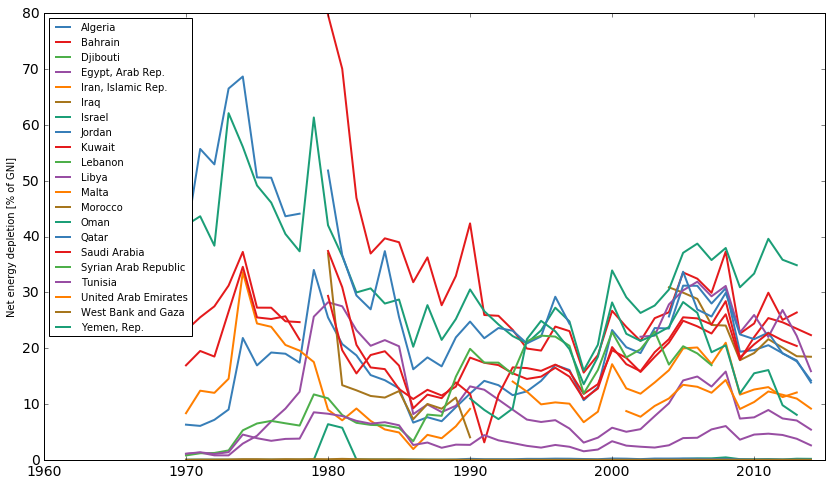

In [373]:
# Energy depletion is the biggest potential drain on GNI. So let's look at the
# region most strongly affected (Middle East & North Africa) and split by country.

depletion_code = "NY.ADJ.DNGY.GN.ZS"

fig,ax = plt.subplots(1,1,figsize=(14,8))

d = data[(data['Indicator Code'] == depletion_code) &
         (data['Country Code'].isin(country[country['Region'] == "Middle East & North Africa"]['Country Code']))]

# Limit to countries with at least 20 non-NaN data points?

#d = d[np.isnan(d[d.columns[4:]]).sum(axis=1) < 20]

d.index = d['Country Name']
dt = d[d.columns[4:]].T

dt.plot(ax=ax,legend=True,fontsize=14)
ax.set_ylabel("Net {} depletion [% of GNI]".format(label),fontsize=10)
ax.legend(fontsize=10,loc='upper left');

In [387]:
# Colors cycle through slightly, so it's not obvious from the legend
# which countries have the highest energy depletion. 

x = d["1990"][::]
print x.sort_values(ascending=False)

Country Name
Bahrain                 42.368273
Oman                    30.533981
Qatar                   24.770941
Syrian Arab Republic    19.886923
Saudi Arabia            18.313006
Egypt, Arab Rep.        13.159706
Algeria                 11.868904
Kuwait                  11.811606
Yemen, Rep.             10.983085
Iran, Islamic Rep.       9.122626
Iraq                     4.028901
Tunisia                  2.674197
Jordan                   0.176594
Morocco                  0.010536
Israel                   0.004384
Malta                    0.000000
Lebanon                  0.000000
Djibouti                      NaN
Libya                         NaN
United Arab Emirates          NaN
West Bank and Gaza            NaN
Name: 1990, dtype: float64


Bahrain, Oman, and Qatar have had the highest energy depletion rates consistently since 1999.

In [294]:
print d[d["2010"] < 1]['Country Code']

Country Name
Israel     ISR
Jordan     JOR
Malta      MLT
Morocco    MAR
Name: Country Code, dtype: object


In [344]:
print np.mean(d[d["2010"] < 1][["2010","2011","2012","2013","2014","2015"]],axis=1)

Country Name
Israel     0.130016
Jordan     0.037069
Malta      0.000000
Morocco    0.012343
dtype: float64


In [390]:
for c in ("Israel","Jordan","Malta","Morocco"):
    print "{:10} average is {:.3f}".format(c,np.nanmean(d[d.index == c].values[0][4:].astype(float)))

Israel     average is 0.322
Jordan     average is 0.080
Malta      average is 0.000
Morocco    average is 0.037


On the other end of the scale, four countries (Israel, Malta, Jordan, Morocco) are currently at essentially zero net energy depletion (all less than 0.15% of GNI) and historically always have been, with the exception of a brief spike for Israel around the year 1980. A couple of these countries are outliers with respect to the group; Malta is a Mediterranean island and a member of the EU/Eurozone, while Israel is the only Jewish-majority state and has famously strained relations with the majority of the other countries in this group. It's not as clear why Jordan and Morocco are much lower, but neither is a large oil producer or OPEC member.

So, the question I'd like to try and tackle - are countries with a rising rate of energy depletion focusing on other areas that can offset a finite amount of natural resources?

I'll pick a couple areas I think they could invest in:

- tourism
- research and development
- education

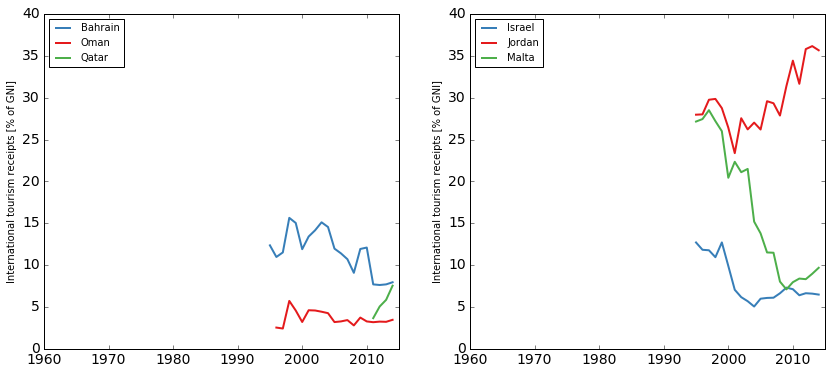

In [402]:
# Tourism

tourism_code = "ST.INT.RCPT.XP.ZS"

# Plot tourism income vs energy depletion for Oman

fig,axarr = plt.subplots(1,2,figsize=(14,6))
energy_depleting = ["Bahrain","Oman","Qatar"]
energy_nondepleting = ["Jordan","Israel","Malta"]
for ax,clist in zip(axarr.ravel(),(energy_depleting,energy_nondepleting)):

    d = data[(data['Indicator Code'] == tourism_code) & 
             (data['Country Name'].isin(clist))]

    d.index = d['Country Name']
    dt = d[d.columns[4:]].T

    dt.plot(ax=ax,legend=True,fontsize=14)
    ax.set_ylabel("International tourism receipts [% of GNI]",fontsize=10)
    ax.legend(fontsize=10,loc='upper left')
    ax.set_ylim(0,40);

There's a huge overall gap between the two classes; countries with the highest energy depletion have less than 15% of their GNI from tourism. For Qatar, it's rising sharply (with only a few years of data), which might indicate diversification in the face of a pending energy crisis. The development of Doha as an airline hub and rapidly expanding city would support that. 

For countries with low energy depletion, tourism is a much higher fraction. Jordan is the highest and still increasing (maybe for sites like Petra). Malta's tourism income has taken a massive fall, which is very odd; Israel dropped around 2000, but has been holding steady.  

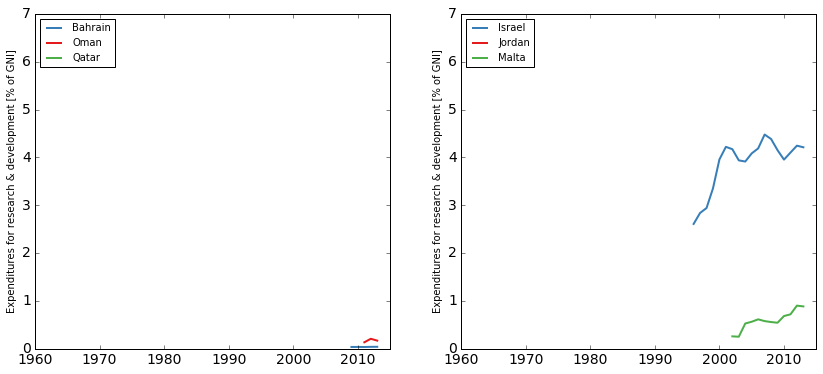

In [405]:
# Research

research_code = "GB.XPD.RSDV.GD.ZS"

# Plot tourism income vs energy depletion for Oman

fig,axarr = plt.subplots(1,2,figsize=(14,6))

for ax,clist in zip(axarr.ravel(),(energy_depleting,energy_nondepleting)):

    d = data[(data['Indicator Code'] == research_code) & 
             (data['Country Name'].isin(clist))]

    d.index = d['Country Name']
    dt = d[d.columns[4:]].T

    dt.plot(ax=ax,legend=True,fontsize=14)
    ax.set_ylabel("Expenditures for research & development [% of GNI]",fontsize=10)
    ax.legend(fontsize=10,loc='upper left')
    ax.set_ylim(0,7);

The top energy-depleting companies have virtually no significant money spent on R&D, interestingly (seems like a bad move). Israel has a thriving output, Malta less so. No data on Jordan. 

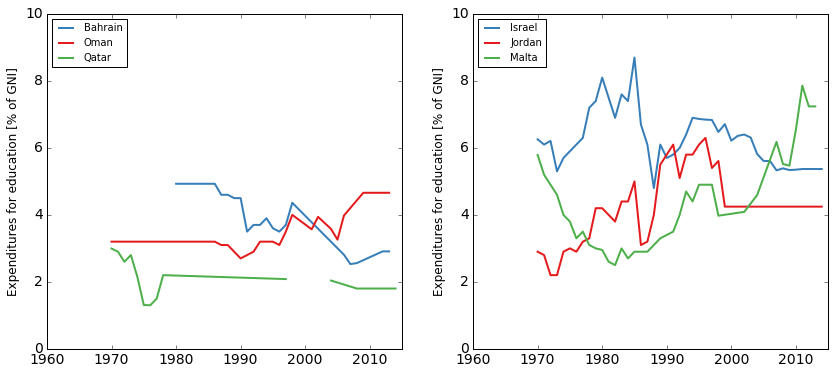

In [410]:
# Education

education_code = "NY.ADJ.AEDU.GN.ZS"

# Plot tourism income vs energy depletion for Oman

fig,axarr = plt.subplots(1,2,figsize=(14,6))

for ax,clist in zip(axarr.ravel(),(energy_depleting,energy_nondepleting)):

    d = data[(data['Indicator Code'] == education_code) & 
             (data['Country Name'].isin(clist))]

    d.index = d['Country Name']
    dt = d[d.columns[4:]].T

    dt.plot(ax=ax,legend=True,fontsize=14)
    ax.set_ylabel("Expenditures for education [% of GNI]",fontsize=12)
    ax.legend(fontsize=10,loc='upper left')
    ax.set_ylim(0,10);

More varied story here: energy-depleting countries have fewer data, but Qatar is essentially flat and Bahrain dropping, although Oman appears to be on the rise. The non-energy depleting countries are slightly higher on average, but only by ~50%. Malta is rising again after a decade-long low point.

*I need to end it here and focus on other things now. I didn't quite get where I wanted with this data challenge; I wanted to see if I could build a model for other countries facing similar energy depletion concerns who would be good candidates to reinvest in the areas I highlighted above. I didn't end up having the time, but there are a couple potential issues: the metadata for how energy depletion is measured still isn't completely clear to me. More importantly, there isn't a particularly strong correlation between energy depletion and the factors I looked at.* 

*I want to develop a couple better metrics (ie, total amount and rate of change in a specific recent time period) for these data and then build a model on top of that. Hopefully will come back to this at some point. -KW*